In [1]:
import os
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler
import cv2

/home/vera/miniconda3/envs/ails/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load jpeg images from a directory and convert them to numpy arrays
def load_images(directory):
    images = []
    for filename in glob.glob(directory + '/*.jpg'):
        img = Image.open(filename)
        img = np.array(img)
        images.append(img)
    return np.array(images)



def points_out_of_graph(data_embedded, data, x_axis_threshold, y_axis_theshold, x_over=True, y_over=True):
    if x_over:
        if y_over:
            indices = np.where((data_embedded[:, 0] > x_axis_threshold) & (data_embedded[:, 1] > y_axis_theshold))[0]
        else:
            indices = np.where((data_embedded[:, 0] > x_axis_threshold) & (data_embedded[:, 1] < y_axis_theshold))[0]
    else:
        if y_over:
            indices = np.where((data_embedded[:, 0] < x_axis_threshold) & (data_embedded[:, 1] > y_axis_theshold))[0]
        else:
            indices = np.where(data_embedded[:, 0] < x_axis_threshold)[0] & (data_embedded[:, 1] < y_axis_theshold)[0]


    points = data[indices]

    print(f"There are {len(points)} points\n")
    print(f"Indices of the points are: {indices}\n")
    return indices

def analyze_hsv(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hue, saturation, value = cv2.split(hsv_image)
    
    # Chroma is defined as the difference between the maximum and minimum RGB values
    r, g, b = cv2.split(image)
    chroma = np.maximum(np.maximum(r, g), b) - np.minimum(np.minimum(r, g), b)
    
    return hue, saturation, chroma


In [122]:
dataset = load_images("/home/vera/Documents/AI/AILS-MICCAI-UWF4DR-Challenge/data/raw/UWF4DRChallengeData/Task 1 Image Quality Assessment/1. Images/1. Training")


In [4]:
n_samples, h, w, c = data.shape
flattened_images = data.reshape(n_samples, -1)

# Standardize the data
scaler = StandardScaler()
flattened_images_scaled = scaler.fit_transform(flattened_images)

# Apply PCA
n_components = 2  # Number of principal components to keep
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(flattened_images_scaled)

KeyboardInterrupt: 

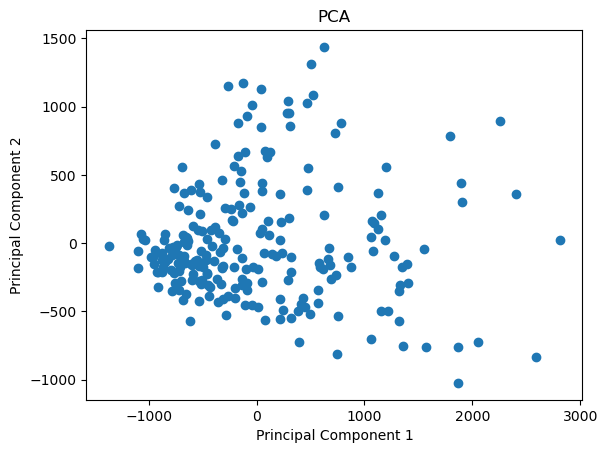

In [ ]:
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()

In [ ]:
points_out_of_graph(principal_components, data, 2000, -1000, x_over=True, y_over=True)

There are 5 points

Indices of the points are: [ 35  52  83 149 220]



array([ 35,  52,  83, 149, 220])

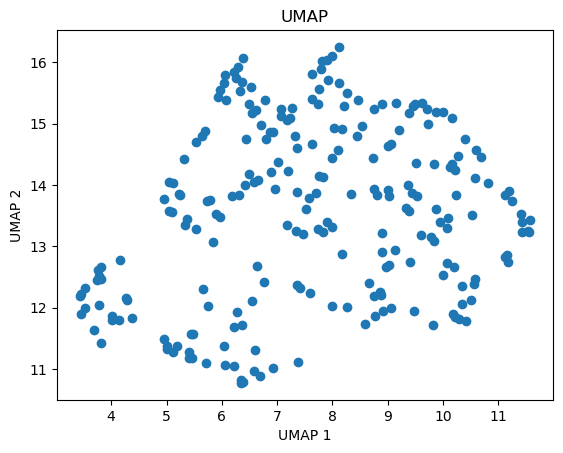

In [ ]:
umap_model = umap.UMAP(n_components=2, n_neighbors=5)
umap_embedding = umap_model.fit_transform(flattened_images_scaled)

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1])
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP')
plt.show()


In [ ]:
indices = points_out_of_graph(umap_embedding, data, 4.9, 0, x_over=False, y_over=True)


There are 20 points

Indices of the points are: [  5  19  33  36  43  44  51  55  65  99 103 113 120 125 138 151 168 187
 196 218]



In [123]:
image = dataset[2]
gray_image = cv2.cvtColor(data[0], cv2.COLOR_RGB2GRAY)
_, binary = cv2.threshold(gray_image, 60, 255, cv2.THRESH_BINARY)
plt.imshow(image, cmap='gray')


KeyError: 0

In [97]:
#change working directory
os.chdir('/home/vera/vsc5/data/projects/AILS-MICCAI-UWF4DR-Challenge')

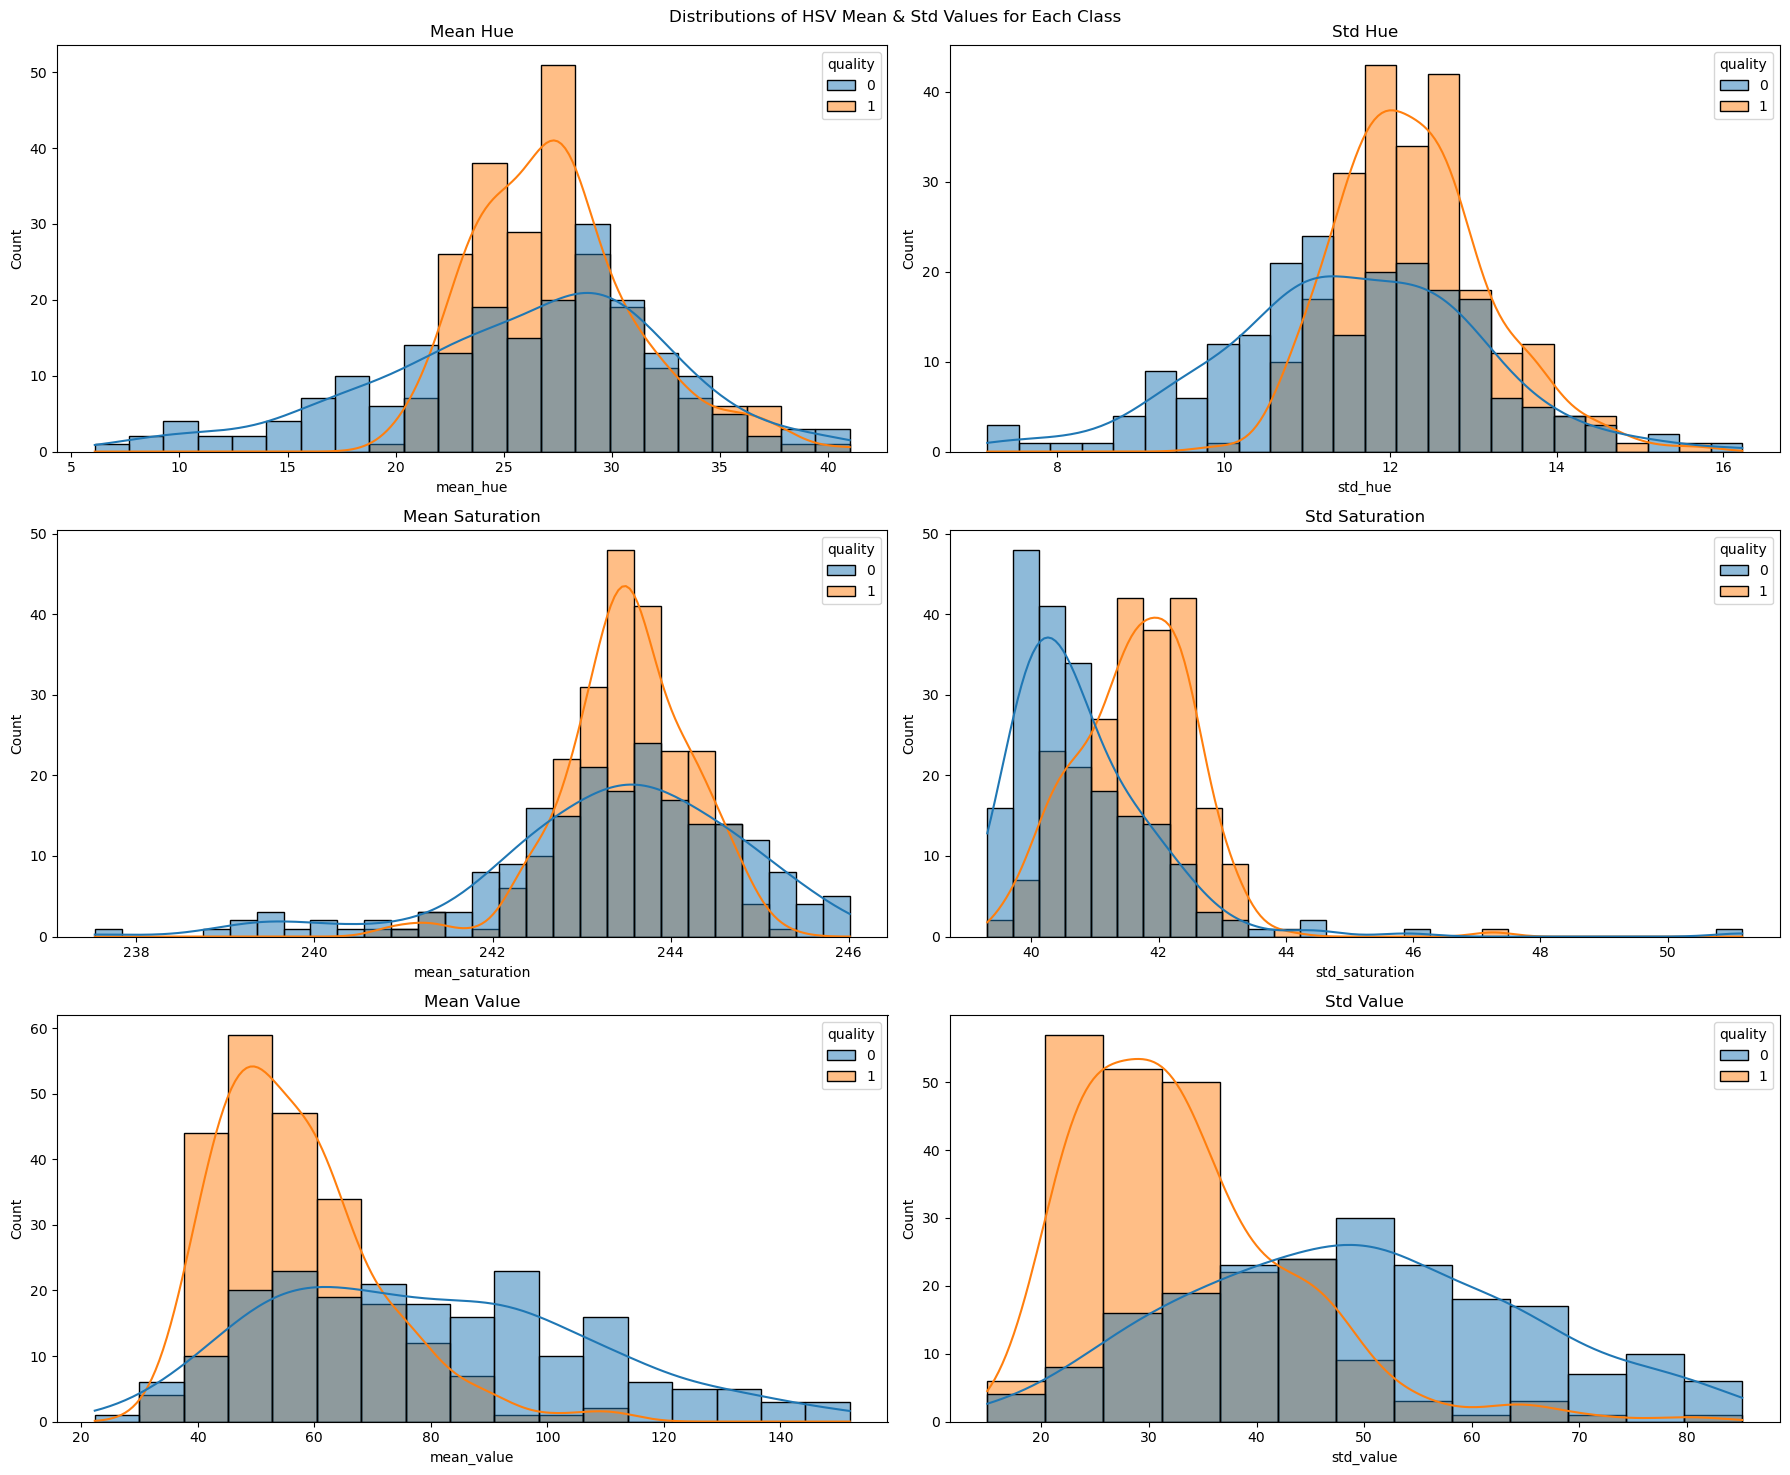

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import numpy as np

# Import your dataset module
from ails_miccai_uwf4dr_challenge.dataset import ChallengeTaskType, DatasetBuilder, DatasetOriginationType

# Load the dataset
dataset_builder = DatasetBuilder(dataset=DatasetOriginationType.ORIGINAL, task=ChallengeTaskType.TASK1)
data = dataset_builder.get_unsplit_dataframe()

# Function to get HSV image stats
def get_hsv_stats(image_path):
    image = plt.imread(str(image_path))
    hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    mean_hue = hsv_image[:, :, 0].mean()
    std_hue = hsv_image[:, :, 0].std()
    mean_saturation = hsv_image[:, :, 1].mean()
    std_saturation = hsv_image[:, :, 1].std()
    mean_value = hsv_image[:, :, 2].mean()
    std_value = hsv_image[:, :, 2].std()
    
    return pd.Series([mean_hue, std_hue, mean_saturation, std_saturation, mean_value, std_value], 
                     index=['mean_hue', 'std_hue', 'mean_saturation', 'std_saturation', 'mean_value', 'std_value'])

# Apply the HSV stats function to each image
image_stats = data['image'].apply(get_hsv_stats)

# Add the stats to the original DataFrame
data[['mean_hue', 'std_hue', 'mean_saturation', 'std_saturation', 'mean_value', 'std_value']] = image_stats

# Plot the distribution of mean and std for each HSV channel
fig, axs = plt.subplots(3, 2, figsize=(18, 15))

sns.histplot(data, x='mean_hue', hue='quality', kde=True, ax=axs[0, 0])
sns.histplot(data, x='std_hue', hue='quality', kde=True, ax=axs[0, 1])
sns.histplot(data, x='mean_saturation', hue='quality', kde=True, ax=axs[1, 0])
sns.histplot(data, x='std_saturation', hue='quality', kde=True, ax=axs[1, 1])
sns.histplot(data, x='mean_value', hue='quality', kde=True, ax=axs[2, 0])
sns.histplot(data, x='std_value', hue='quality', kde=True, ax=axs[2, 1])

# Set titles
axs[0, 0].set_title('Mean Hue')
axs[0, 1].set_title('Std Hue')
axs[1, 0].set_title('Mean Saturation')
axs[1, 1].set_title('Std Saturation')
axs[2, 0].set_title('Mean Value')
axs[2, 1].set_title('Std Value')

fig.suptitle('Distributions of HSV Mean & Std Values for Each Class')

plt.tight_layout()
plt.show()


AxesImage(shape=(800, 1016, 3))


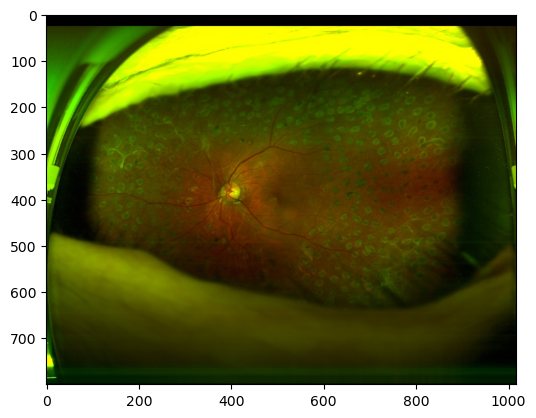

In [138]:
print(plt.imshow(dataset[2]))

In [186]:
import cv2
import numpy as np

# Step 1: Automatically choose the initial seed position
def choose_seed_position(image):
    m, n = image.shape
    seed_x, seed_y = m // 2, n // 2

    # Check pixel intensity at the initial seed position
    if image[seed_x, seed_y] < 50:  # Threshold to detect black region
        seed_x += 5  # Shift in x direction
        seed_y += 5  # Shift in y direction

    return seed_x, seed_y

# Step 2: Region growing
def region_growing(image, seed_x, seed_y, threshold=10):
    mask = np.zeros_like(image, dtype=np.uint8)
    mask[seed_x, seed_y] = 1
    grow = True
    while grow:
        grow = False
        mask_copy = mask.copy()
        for x in range(1, image.shape[0] - 1):
            for y in range(1, image.shape[1] - 1):
                if mask_copy[x, y] == 1:
                    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        if mask[x + dx, y + dy] == 0 and abs(int(image[x + dx, y + dy]) - int(image[x, y])) < threshold:
                            mask[x + dx, y + dy] = 1
                            grow = True
    return mask

# Step 3: Invert the image mask
def invert_mask(mask):
    return 1 - mask

# Step 4: Morphological opening to remove small white regions
def morphological_opening(mask, kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return opened_mask

# Example usage
image = dataset[2]
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Step 1: Choose initial seed position
seed_x, seed_y = choose_seed_position(image)

# Step 2: Perform region growing
mask = region_growing(image, seed_x, seed_y)

# Step 3: Invert the image mask
inverted_mask = invert_mask(mask)

# Step 4: Perform morphological opening
cleaned_mask = morphological_opening(inverted_mask)

# Display the results
cv2.imshow('Original Image', image)
cv2.imshow('Region Grown Mask', mask * 255)
cv2.imshow('Inverted Mask', inverted_mask * 255)
cv2.imshow('Cleaned Mask', cleaned_mask * 255)
cv2.waitKey(0)
cv2.destroyAllWindows()


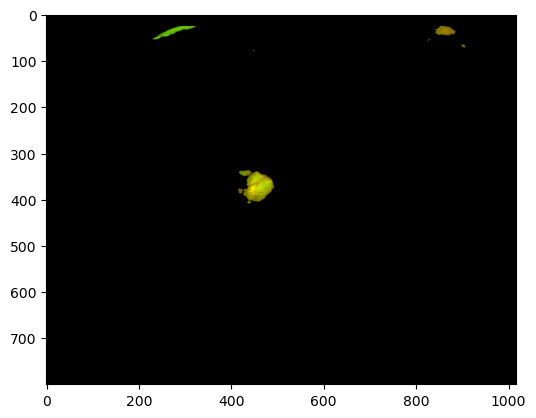

In [169]:
 # Convert BGR to HSV
image = dataset[0]

hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
# define range of blue color in HSV
lower_blue = np.array([0,50,120])
upper_blue = np.array([180,255,255])
binary = cv.inRange(hsv, lower_blue, upper_blue)
# Create a mask that retains the center region
side_margin_ratio = 0.1
height, width = binary.shape
side_margin_width = int(width * side_margin_ratio)



center_mask = np.zeros_like(binary)
center_mask[:, side_margin:width-side_margin] = 1

# Combine the binary mask and the center mask
final_mask = binary * center_mask

# Apply the final mask to the original image
masked_image = cv2.bitwise_and(image, image, mask=final_mask)
plt.imshow(masked_image)


In [185]:
_, blackAndWhite = cv.threshold(image, 127, 255, cv.THRESH_BINARY_INV)
nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(blackAndWhite)
sizes = stats[1:, -1]  # get CC_STAT_AREA component
image = np.zeros(labels.shape, np.uint8)

for i in range(0, nlabels - 1):
    if sizes[i] >= 150:  # filter small dotted regions
        image[labels == i + 1] = 255

error: OpenCV(4.10.0) /home/conda/feedstock_root/build_artifacts/libopencv_1718892979884/work/modules/imgproc/src/connectedcomponents.cpp:5623: error: (-215:Assertion failed) L.channels() == 1 && I.channels() == 1 in function 'connectedComponents_sub1'


In [184]:
    # Find all non-zero points (pixels with value 1)
points = cv2.findNonZero(binary)
print(points)
    # Get the minimum enclosing ellipse

mask = np.zeros_like(image)
cv.ellipse(mask, ellipse, (255, 255, 255), -1)
result = cv2.bitwise_and(image, mask)


[[[287  26]]

 [[288  26]]

 [[289  26]]

 ...

 [[  3 787]]

 [[  4 787]]

 [[  5 787]]]


NameError: name 'ellipse' is not defined

In [183]:
import cv2 
import numpy as np


img = dataset[0]
#img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

circles = cv2.HoughCircles(cimg, cv2.HOUGH_GRADIENT, 1.2, 200)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    center=(i[0],i[1])
    radius=i[2]
  #  cv2.circle(img,(i[0],i[1]),i[2],(0,0,0),2)
    # draw the center of the circle
  #  cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
    print(i[0],i[1])

center=(center[0],center[1])
radius=radius
print(center)
print(radius)

mask=np.zeros(img.shape[:], dtype=np.uint8)
cv2.circle(mask,center,radius,(255,255,255),thickness=-1)

# the mask will be a bgr image
# has to be converted to grayscale for threshholding
mask=cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)


# threshholding the grayscale image to get a binary image, with max_value 1
ret,mask=cv2.threshold(mask,10,1,cv2.THRESH_BINARY)

# the mask is multiplied with all 3 channels of the original image 
b=np.multiply(img[:,:,0],mask)
g=np.multiply(img[:,:,1],mask)
r=np.multiply(img[:,:,2],mask)

# img_final combines these 3 seperated channels to get the final Fundus image
img_final=np.zeros(img.shape[:])
img_final=np.uint8(img_final)
img_final[:,:,0]=b
img_final[:,:,1]=g
img_final[:,:,2]=r

# the mask and final image are resized for displaying on screen


cv2.imshow('detected circles',img)
cv2.imshow('mask',mask)
cv2.imshow('filtered',filtered)
cv2.imwrite('owlFiltered.jpg',filtered)


#cv2.imshow('detected circles',img)
cv2.waitKey(0)
cv2.destroyAllWindows() 

TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable rint method

957 1001 0 799


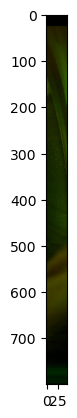

In [163]:
# inverse mask
mask = binary < 1
plt.imshow(mask, cmap='gray')
rows = np.all(mask, axis=1)
cols = np.all(mask, axis=0)
y_min, y_max = np.where(rows)[0][[0, -1]]
x_min, x_max = np.where(cols)[0][[0, -1]]
print(x_min, x_max, y_min, y_max)
rect_region = image[y_min:y_max+1, x_min:x_max+1]
plt.imshow(rect_region)

In [141]:
side_margin_ratio = 0.1

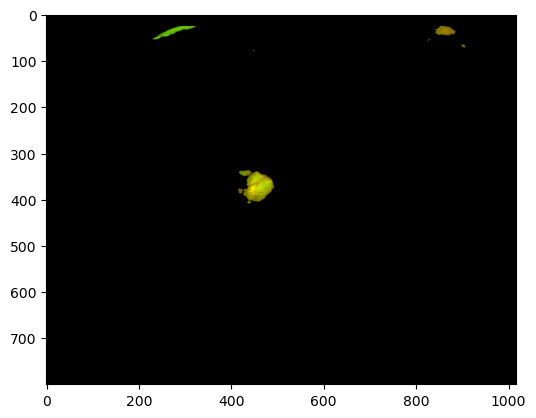

In [145]:
plt.imshow(masked_image)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


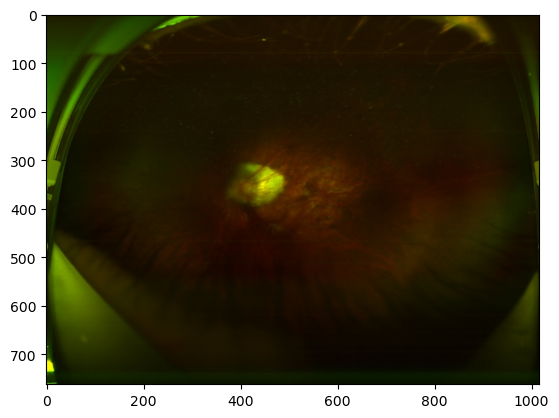

In [42]:
mask = binary > 6
print(mask)
rows = np.any(mask, axis=1)
cols = np.any(mask, axis=0)
y_min, y_max = np.where(rows)[0][[0, -1]]
x_min, x_max = np.where(cols)[0][[0, -1]]
rect_region = image[y_min:y_max+1, x_min:x_max+1]
plt.imshow(rect_region)

In [ ]:
import cv2
import numpy as np

def process_image(image_path, tolerance=6):
    # Step 1: Convert the image to grayscale
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Set pixel values: white to 255 and black to 0
    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

    # Step 2: Generate the mask
    mask = binary_image > tolerance

    # Step 3: Identify the rectangular region
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    
    if not np.any(rows) or not np.any(cols):
        print("No region found with the given tolerance.")
        return None, None

    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]

    # Step 4: Extract the region in RGB format
    rect_region = image[y_min:y_max+1, x_min:x_max+1]

    return rect_region, mask

# Example Usage
image_path = 'path_to_your_image.jpg'
tolerance = 6  # Default tolerance

rect_region, mask = process_image(image_path, tolerance)

if rect_region is not None:
    # Display the results
    cv2.imshow('Rectangular Region', rect_region)
    cv2.imshow('Mask', mask.astype(np.uint8) * 255)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the result if needed
    cv2.imwrite('extracted_region.jpg', rect_region)
else:
    print("No valid region found based on the specified tolerance.")


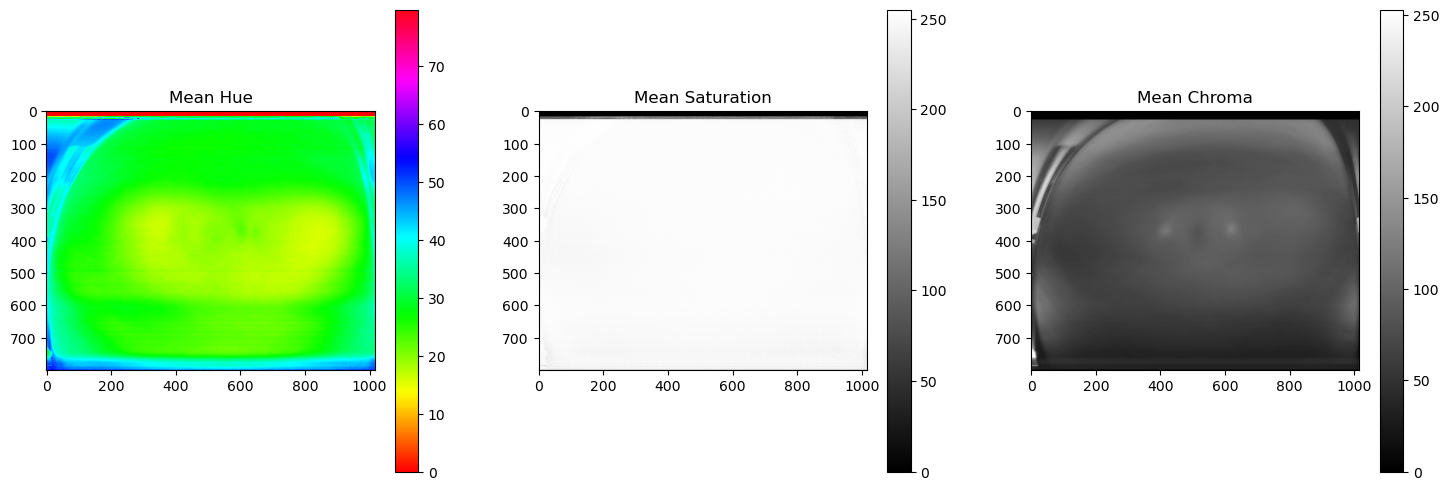

In [ ]:


# Initialize lists to hold the extracted components
hue_list = []
saturation_list = []
chroma_list = []

# Process each image
for img in data:
    hue, saturation, chroma = analyze_hsv(img)
    hue_list.append(hue)
    saturation_list.append(saturation)
    chroma_list.append(chroma)

# Convert lists to numpy arrays for further analysis
hue_array = np.array(hue_list)
saturation_array = np.array(saturation_list)
chroma_array = np.array(chroma_list)

#plot the mean hue, saturation, and chroma
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.mean(hue_array, axis=0), cmap='hsv')
plt.title('Mean Hue')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(np.mean(saturation_array, axis=0), cmap='gray')
plt.title('Mean Saturation')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.mean(chroma_array, axis=0), cmap='gray')
plt.title('Mean Chroma')
plt.colorbar()

plt.show()



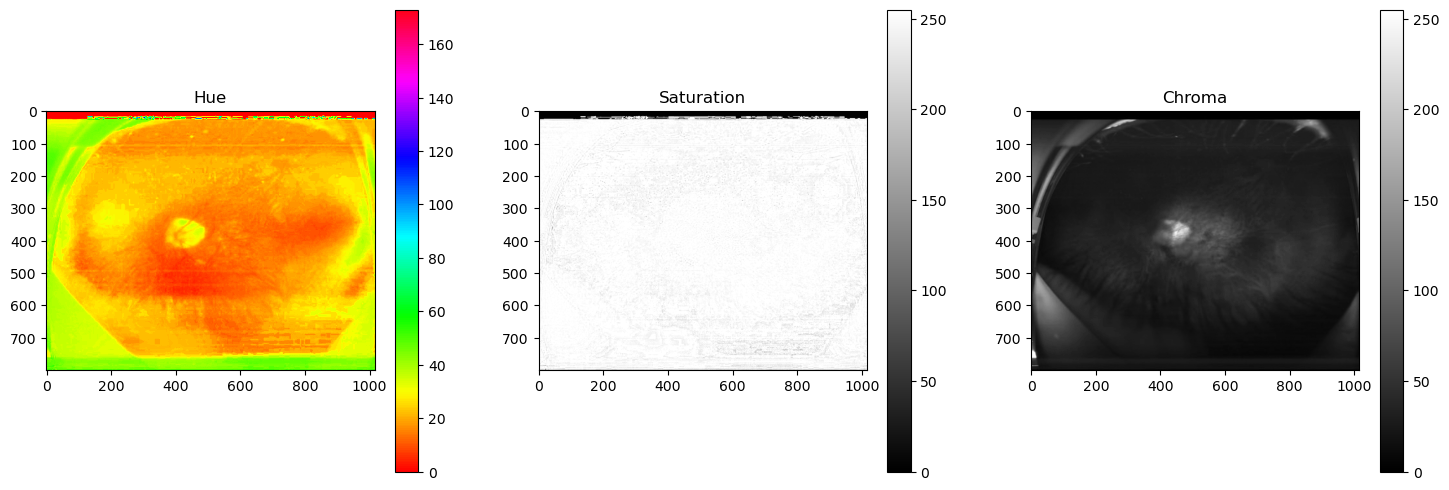

In [ ]:

# Visualize the average hue, saturation, and chroma for the first image as an example
example_index = 0
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(hue_array[example_index], cmap='hsv')
plt.title('Hue')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(saturation_array[example_index], cmap='gray')
plt.title('Saturation')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(chroma_array[example_index], cmap='gray')
plt.title('Chroma')
plt.colorbar()

plt.show()


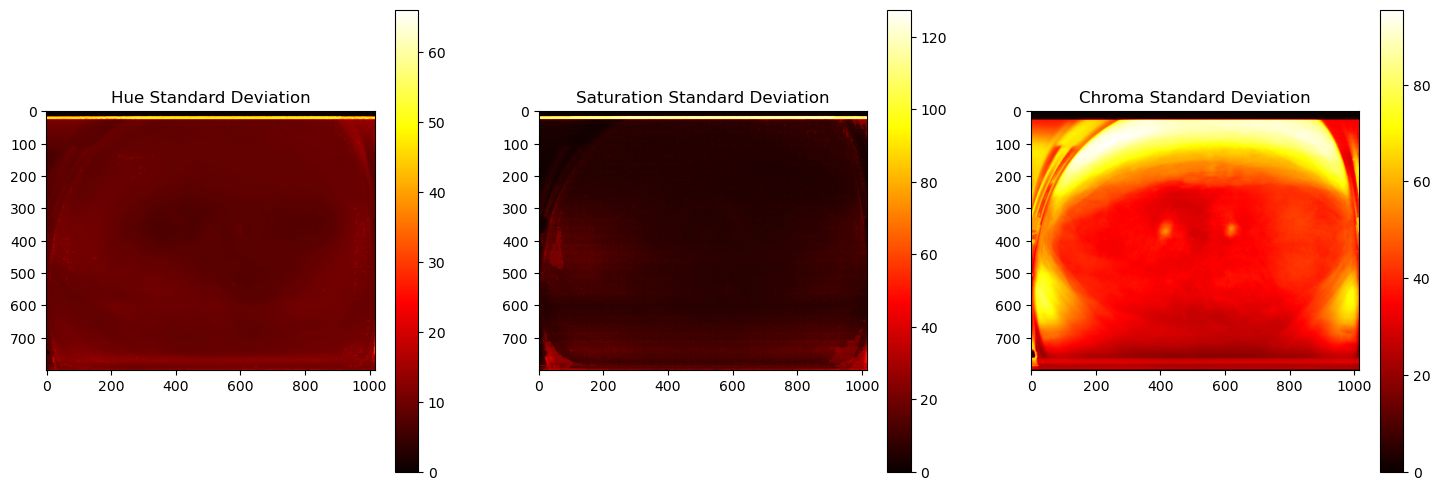

In [ ]:
hue_std = np.std(hue_array, axis=0)
saturation_std = np.std(saturation_array, axis=0)
chroma_std = np.std(chroma_array, axis=0)

# Plot the standard deviation maps
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(hue_std, cmap='hot')
plt.title('Hue Standard Deviation')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(saturation_std, cmap='hot')
plt.title('Saturation Standard Deviation')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(chroma_std, cmap='hot')
plt.title('Chroma Standard Deviation')
plt.colorbar()

plt.show()


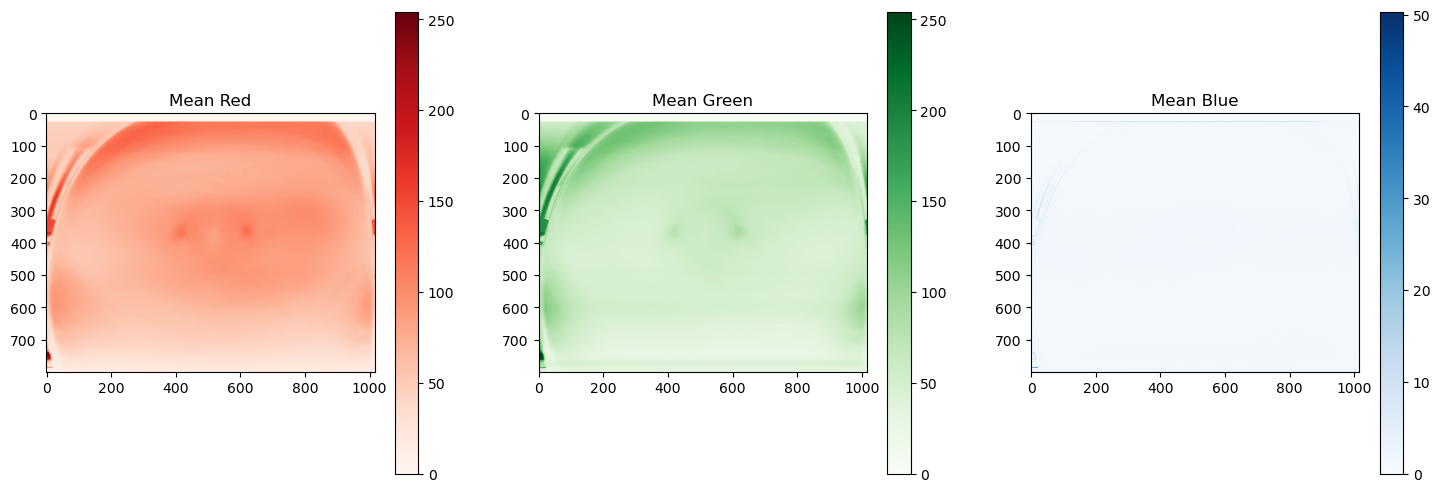

In [ ]:
red_list = []
green_list = []
blue_list = []

# Process each image
for img in data:
    red, green, blue = cv2.split(img)
    red_list.append(red)
    green_list.append(green)
    blue_list.append(blue)

red_array = np.array(red_list)
green_array = np.array(green_list)
blue_array = np.array(blue_list)


plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.mean(red_array, axis=0), cmap='Reds')
plt.title('Mean Red')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(np.mean(green_array, axis=0), cmap='Greens')
plt.title('Mean Green')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.mean(blue_array, axis=0), cmap='Blues')
plt.title('Mean Blue')
plt.colorbar()

plt.show()


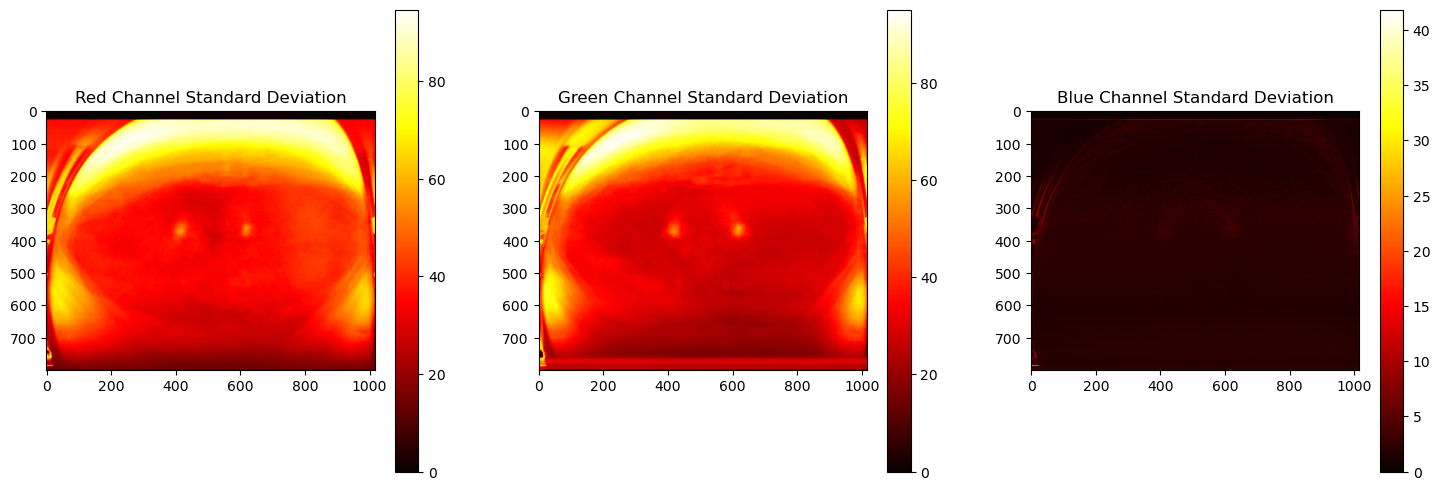

In [ ]:

# Plot the standard deviation maps
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(np.std(red_array, axis=0), cmap='hot')
plt.title('Red Channel Standard Deviation')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(np.std(green_array, axis=0), cmap='hot')
plt.title('Green Channel Standard Deviation')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.std(blue_array, axis=0), cmap='hot')
plt.title('Blue Channel Standard Deviation')
plt.colorbar()

plt.show()